In [1]:
import jax
import jax.numpy as jnp
import jax.tree_util as jtu
import time
import os
from dataclasses import dataclass
from collections import namedtuple
import pyro
import optax
from pyro.infer import SVI, TraceGraph_ELBO
import pyro.distributions as dist
import pyro.poutine as poutine
import pyro.contrib.examples.multi_mnist as multi_mnist
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.gridspec import GridSpec
import matplotlib.font_manager as font_manager
from matplotlib.patches import Rectangle
import matplotlib.ticker as ticker
import matplotlib.patches as patches
import seaborn as sns
from matplotlib import cm
from matplotlib.ticker import LinearLocator
from matplotlib import rcParams
from scipy.interpolate import griddata
import genjax
from genjax import grasp

console = genjax.pretty()
key = jax.random.PRNGKey(314159)
sns.set_theme(style="white")
font_path = (
    "/home/femtomc/.local/share/fonts/Unknown Vendor/TrueType/Lato/Lato_Bold.ttf"
)
font_manager.fontManager.addfont(font_path)
custom_font_name = font_manager.FontProperties(fname=font_path).get_name()
rcParams["font.family"] = custom_font_name

key = jax.random.PRNGKey(314159)
label_fontsize = 70  # Set the desired font size here

smoke_test = "CI" in os.environ
assert pyro.__version__.startswith("1.8.6")

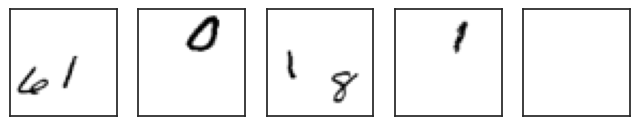

In [2]:
inpath = "./data/air/.data"
X_np, Y = multi_mnist.load(inpath)
X_np = X_np.astype(np.float32)
X_np /= 255.0
mnist = jnp.array(X_np)
true_counts = jnp.array([len(objs) for objs in Y])


def show_images(imgs):
    fig = plt.figure(figsize=(8, 2))
    for i, img in enumerate(imgs):
        ax = plt.subplot(1, len(imgs), i + 1)
        ax.set_xticks([])
        ax.set_yticks([])
        plt.imshow(img, cmap="gray_r")


show_images(mnist[9:14])

## Defining the variational ingredients

### Utilities / learnable pieces

In [3]:
from genjax import Pytree
import equinox as eqx
from genjax.typing import Any
from genjax.typing import Tuple
from genjax.typing import FloatArray
from genjax.typing import Int
from genjax.typing import IntArray
from genjax.typing import PRNGKey
from genjax.typing import typecheck

# Utilities for defining the model and the guide.


@dataclass
class Decoder(Pytree):
    dense_1: Any
    dense_2: Any

    def flatten(self):
        return (self.dense_1, self.dense_2), ()

    @classmethod
    def new(cls, key1, key2):
        dense_1 = eqx.nn.Linear(50, 200, key=key1)
        dense_2 = eqx.nn.Linear(200, 400, key=key2)
        return Decoder(dense_1, dense_2)

    def __call__(self, z_what):
        v = self.dense_1(z_what)
        v = jax.nn.leaky_relu(v)
        v = self.dense_2(v)
        return jax.nn.sigmoid(v)


# Create our decoder.
key, sub_key1, sub_key2 = jax.random.split(key, 3)
decoder = Decoder.new(sub_key1, sub_key2)

# Create our RNN for the guide.
key, sub_key = jax.random.split(key)
rnn = eqx.nn.LSTMCell(2554, 256, key=sub_key)


@dataclass
class Encoder(Pytree):
    dense_1: Any
    dense_2: Any

    def flatten(self):
        return (self.dense_1, self.dense_2), ()

    @classmethod
    def new(cls, key1, key2):
        dense_1 = eqx.nn.Linear(400, 200, key=key1)
        dense_2 = eqx.nn.Linear(200, 100, key=key2)
        return Encoder(dense_1, dense_2)

    def __call__(self, data):
        v = self.dense_1(data)
        v = jax.nn.leaky_relu(v)
        v = self.dense_2(v)
        return v[0:50], jax.nn.softplus(v[50:])


key, sub_key1, sub_key2 = jax.random.split(key, 3)
encoder = Encoder.new(sub_key1, sub_key2)


@dataclass
class Predict(Pytree):
    dense: Any

    def flatten(self):
        return (self.dense,), ()

    @classmethod
    def new(cls, key):
        dense = eqx.nn.Linear(256, 7, key=key)
        return Predict(dense)

    def __call__(self, h):
        a = self.dense(h)
        z_pres_p = jax.nn.sigmoid(a[0:1])
        z_where_loc = a[1:4]
        z_where_scale = jax.nn.softplus(a[4:])
        return z_pres_p, z_where_loc, z_where_scale


key, sub_key = jax.random.split(key)
predict = Predict.new(key)

In [4]:
#######
# STN #
#######

# modified from https://github.com/kevinzakka/spatial-transformer-network/blob/master/stn/transformer.py


def affine_grid_generator(height, width, theta):
    """
    This function returns a sampling grid, which when
    used with the bilinear sampler on the input feature
    map, will create an output feature map that is an
    affine transformation [1] of the input feature map.

    Input
    -----
    - height: desired height of grid/output. Used
      to downsample or upsample.

    - width: desired width of grid/output. Used
      to downsample or upsample.

    - theta: affine transform matrices of shape (num_batch, 2, 3).
      For each image in the batch, we have 6 theta parameters of
      the form (2x3) that define the affine transformation T.

    Returns
    -------
    - normalized grid (-1, 1) of shape (num_batch, 2, H, W).
      The 2nd dimension has 2 components: (x, y) which are the
      sampling points of the original image for each point in the
      target image.

    Note
    ----
    [1]: the affine transformation allows cropping, translation,
         and isotropic scaling.
    """
    num_batch = theta.shape[0]

    # create normalized 2D grid
    x = jnp.linspace(-1.0, 1.0, width)
    y = jnp.linspace(-1.0, 1.0, height)
    x_t, y_t = jnp.meshgrid(x, y)

    # flatten
    x_t_flat = jnp.reshape(x_t, [-1])
    y_t_flat = jnp.reshape(y_t, [-1])

    # reshape to [x_t, y_t , 1] - (homogeneous form)
    ones = jnp.ones_like(x_t_flat)
    sampling_grid = jnp.stack([x_t_flat, y_t_flat, ones])

    # repeat grid num_batch times
    sampling_grid = jnp.expand_dims(sampling_grid, axis=0)
    sampling_grid = jnp.tile(sampling_grid, [num_batch, 1, 1])

    # transform the sampling grid - batch multiply
    batch_grids = jnp.matmul(theta, sampling_grid)
    # batch grid has shape (num_batch, 2, H*W)

    # reshape to (num_batch, 2, H, W)
    batch_grids = jnp.reshape(batch_grids, [num_batch, 2, height, width])

    return batch_grids


def bilinear_sampler(img, x, y):
    """
    Performs bilinear sampling of the input images according to the
    normalized coordinates provided by the sampling grid. Note that
    the sampling is done identically for each channel of the input.

    To test if the function works properly, output image should be
    identical to input image when theta is initialized to identity
    transform.

    Input
    -----
    - img: batch of images in (B, H, W, C) layout.
    - grid: x, y which is the output of affine_grid_generator.

    Returns
    -------
    - out: interpolated images according to grids. Same size as grid.
    """
    H = jnp.shape(img)[1]
    W = jnp.shape(img)[2]
    max_y = H - 1
    max_x = W - 1
    zero = jnp.zeros([], dtype=int)

    # rescale x and y to [0, W-1/H-1]
    x = 0.5 * ((x + 1.0) * max_x - 1)
    y = 0.5 * ((y + 1.0) * max_y - 1)

    # grab 4 nearest corner points for each (x_i, y_i)
    x0 = jnp.floor(x).astype(int)
    x1 = x0 + 1
    y0 = jnp.floor(y).astype(int)
    y1 = y0 + 1

    # clip to range [0, H-1/W-1] to not violate img boundaries
    x0 = jnp.clip(x0, zero, max_x)
    x1 = jnp.clip(x1, zero, max_x)
    y0 = jnp.clip(y0, zero, max_y)
    y1 = jnp.clip(y1, zero, max_y)

    # get pixel value at corner coords
    Ia = get_pixel_value(img, x0, y0)
    Ib = get_pixel_value(img, x0, y1)
    Ic = get_pixel_value(img, x1, y0)
    Id = get_pixel_value(img, x1, y1)

    # recast as float for delta calculation
    x0 = x0.astype(float)
    x1 = x1.astype(float)
    y0 = y0.astype(float)
    y1 = y1.astype(float)

    # calculate deltas
    wa = (x1 - x) * (y1 - y)
    wb = (x1 - x) * (y - y0)
    wc = (x - x0) * (y1 - y)
    wd = (x - x0) * (y - y0)

    # add dimension for addition
    wa = jnp.expand_dims(wa, axis=3)
    wb = jnp.expand_dims(wb, axis=3)
    wc = jnp.expand_dims(wc, axis=3)
    wd = jnp.expand_dims(wd, axis=3)

    # compute output
    out = wa * Ia + wb * Ib + wc * Ic + wd * Id
    return out


def get_pixel_value(img, x, y):
    """
    Utility function to get pixel value for coordinate
    vectors x and y from a  4D tensor image.

    Input
    -----
    - img: tensor of shape (B, H, W, C)
    - x: flattened tensor of shape (B*H*W,)
    - y: flattened tensor of shape (B*H*W,)

    Returns
    -------
    - output: tensor of shape (B, H, W, C)
    """
    batch_size, height, width = jnp.shape(x)

    batch_idx = jnp.arange(0, batch_size)
    batch_idx = jnp.reshape(batch_idx, (batch_size, 1, 1))
    b = jnp.tile(batch_idx, (1, height, width))

    indices = jnp.stack([b, y, x], 3)

    return gather_nd(img, indices)


# from: https://github.com/google/jax/discussions/6119
def gather_nd_unbatched(params, indices):
    return params[tuple(jnp.moveaxis(indices, -1, 0))]


def gather_nd(params, indices, batch=False):
    if not batch:
        return gather_nd_unbatched(params, indices)
    else:
        return vmap(gather_nd_unbatched, (0, 0), 0)(params, indices)


def expand_z_where(z_where):
    # Takes 3-dimensional vectors, and massages them into 2x3 matrices with elements like so:
    # [s,x,y] -> [[s,0,x],
    #             [0,s,y]]
    n = 1
    expansion_indices = jnp.array([1, 0, 2, 0, 1, 3])
    z_where = jnp.expand_dims(z_where, axis=0)
    out = jnp.concatenate((jnp.broadcast_to(jnp.zeros([1, 1]), (n, 1)), z_where), 1)
    return jnp.reshape(out[:, expansion_indices], (n, 2, 3))


def object_to_image(z_where, obj):
    n = 1
    theta = expand_z_where(z_where)
    grid = affine_grid_generator(50, 50, theta)
    x_s = grid[:, 0, :, :]
    y_s = grid[:, 1, :, :]
    out = bilinear_sampler(jnp.reshape(obj, (n, 20, 20, 1)), x_s, y_s)
    return jnp.reshape(out, (50, 50))


def z_where_inv(z_where):
    # Take a batch of z_where vectors, and compute their "inverse".
    # That is, for each row compute:
    # [s,x,y] -> [1/s,-x/s,-y/s]
    # These are the parameters required to perform the inverse of the
    # spatial transform performed in the generative model.
    n = 1
    out = jnp.array([1, *(-z_where[1:])])
    out = out / z_where[0]
    return out


def image_to_object(z_where, image):
    n = 1
    theta_inv = expand_z_where(z_where_inv(z_where))
    grid = affine_grid_generator(20, 20, theta_inv)
    x_s = grid[:, 0, :, :]
    y_s = grid[:, 1, :, :]
    out = bilinear_sampler(jnp.reshape(image, (n, 50, 50, 1)), x_s, y_s)
    return jnp.reshape(out, (400,))

### Model

In [5]:
#########
# Model #
#########

# Fixed constants.
z_where_prior_loc = jnp.array([3.0, 0.0, 0.0])
z_where_prior_scale = jnp.array([0.2, 1.0, 1.0])
z_what_prior_loc = jnp.zeros(50, dtype=float)
z_what_prior_scale = jnp.ones(50, dtype=float)
z_pres_prior = 0.008
eps = 1e-4


@genjax.gen
@typecheck
def step(
    t: Int,
    decoder: Decoder,
    prev_x: FloatArray,
    prev_z_pres: IntArray,
):
    z_pres = grasp.flip_mvd(z_pres_prior ** (2 * t + 1)) @ f"z_pres_{t}"
    z_pres = jnp.array([z_pres.astype(int)])
    z_where = (
        grasp.mv_normal_diag_reparam(z_where_prior_loc, z_where_prior_scale)
        @ f"z_where_{t}"
    )
    z_what = (
        grasp.mv_normal_diag_reparam(z_what_prior_loc, z_what_prior_scale)
        @ f"z_what_{t}"
    )
    y_att = decoder(z_what)
    y = object_to_image(z_where, y_att)
    x = prev_x + (y * z_pres)
    return x, z_pres


# TODO: Make sure that this works, where t is a static int.
@genjax.gen
@typecheck
def model(decoder: Decoder):
    x = jnp.zeros((50, 50), dtype=float)
    z_pres = jnp.ones(1, dtype=int)
    for t in range(3):
        x, z_pres = step.inline(t, decoder, x, z_pres)
    obs = grasp.mv_normal_diag_reparam(x, 0.3 * jnp.ones_like(x)) @ "obs"
    return x

#### Samples from the model

In [6]:
tr = jax.jit(model.simulate)(key, (decoder,))
tr.strip()




├── :z_pres_0
│   └──  bool[]
├── :z_where_1
│   └──  f32[3]
├── :z_where_2
│   └──  f32[3]
├── :z_pres_2
│   └──  bool[]
├── :z_pres_1
│   └──  bool[]
├── :z_where_0
│   └──  f32[3]
├── :z_what_2
│   └──  f32[50]
├── :obs
│   └──  f32[50,50]
├── :z_what_1
│   └──  f32[50]
└── :z_what_0
    └──  f32[50]

### Guide

In [7]:
#########
# Guide #
#########


@genjax.gen
@typecheck
def guide_step(
    t: Int,
    rnn: eqx.nn.LSTMCell,
    encoder: Encoder,
    predict: Predict,
    data,
    prev: Tuple,
):
    (prev_z_where, prev_z_what, prev_z_pres, prev_h, prev_c) = prev
    rnn_input = jnp.concatenate([data, prev_z_where, prev_z_what, prev_z_pres])
    h, c = rnn(rnn_input, (prev_h, prev_c))
    z_pres_p, z_where_loc, z_where_scale = predict(h)
    z_pres = (
        grasp.flip_mvd((eps + (z_pres_p[0] * prev_z_pres[0])) / (1 + 2 * eps))
        @ f"z_pres_{t}"
    )
    z_pres = jnp.array([z_pres.astype(int)])
    z_where = grasp.mv_normal_diag_reparam(z_where_loc, z_where_scale) @ f"z_where_{t}"
    x_att = image_to_object(z_where, data)
    z_what_loc, z_what_scale = encoder(x_att)
    z_what = grasp.mv_normal_diag_reparam(z_what_loc, z_what_scale) @ f"z_what_{t}"
    return z_where, z_what, z_pres, h, c


@genjax.gen
@typecheck
def guide(
    data: genjax.ChoiceMap,
    rnn: eqx.nn.LSTMCell,
    encoder: Encoder,
    predict: Predict,
):
    h = jnp.zeros(256)
    c = jnp.zeros(256)
    z_pres = jnp.ones(1)
    z_where = jnp.zeros(3)
    z_what = jnp.zeros(50)
    img = data["obs"]
    img_arr = img.flatten()

    for t in range(3):
        (z_where, z_what, z_pres, h, c) = guide_step.inline(
            t, rnn, encoder, predict, img_arr, (z_where, z_what, z_pres, h, c)
        )

#### Samples from the guide

In [8]:
data_chm = genjax.choice_map({"obs": jnp.ones((50, 50))})
tr = jax.jit(guide.simulate)(key, (data_chm, rnn, encoder, predict))
tr.strip()




├── :z_pres_0
│   └──  bool[]
├── :z_where_1
│   └──  f32[3]
├── :z_where_2
│   └──  f32[3]
├── :z_pres_2
│   └──  bool[]
├── :z_pres_1
│   └──  bool[]
├── :z_where_0
│   └──  f32[3]
├── :z_what_2
│   └──  f32[50]
├── :z_what_1
│   └──  f32[50]
└── :z_what_0
    └──  f32[50]

## Training

### Make sure grads are working

#### Define ELBO objective

In [9]:
data = genjax.choice_map({"obs": jnp.ones((50, 50))})
objective = grasp.elbo(model, guide, data)
objective



Expectation
└── prog
    └── ADEVProgram
        └── source
            └── <wrapped function elbo_loss>

#### Go go grads

In [10]:
jitted = jax.jit(objective.value_and_grad_estimate)
loss, ((decoder_grads,), (_, rnn_grads, encoder_grads, predict_grads)) = jitted(
    key, ((decoder,), (data, rnn, encoder, predict))
)

In [11]:
loss

Array(-13631.906, dtype=float32)

### Dataloader

In [12]:
def data_loader(
    data,
    batch_size,
    shuffle=True,
):
    N = len(data)
    data_idxs = np.arange(N)
    num_batch = int(np.ceil(N // batch_size))

    def init(key):
        return (
            num_batch,
            jax.random.permutation(key, data_idxs) if shuffle else data_idxs,
        )

    def get_batch(i=0, idxs=data_idxs):
        ret_idx = jax.lax.dynamic_slice_in_dim(idxs, i * batch_size, batch_size)
        return jax.lax.index_take(data, (ret_idx,), axes=(0,))

    return init, get_batch

In [13]:
##################
# Count Accuracy #
##################


def count_accuracy(data, true_counts, guide, batch_size=1000):
    global prng_key
    assert data.shape[0] == true_counts.shape[0], "Size mismatch."
    assert data.shape[0] % batch_size == 0, "Input size must be multiple of batch_size."

    def eval_guide(key, data, params):
        data_chmp = genjax.choice_map({"obs": data})
        return guide.simulate(key, (data_chmp, *params))

    batch_eval_guide = jax.jit(jax.vmap(eval_guide, in_axes=(0, 0, None)))

    @jax.jit
    def evaluate_count_accuracy(key, params):
        def evaluate_batch(counts, batch_id):
            data_batch = jax.lax.dynamic_slice_in_dim(
                data, batch_id * batch_size, batch_size
            )
            true_counts_batch = jax.lax.dynamic_slice_in_dim(
                true_counts, batch_id * batch_size, batch_size
            )
            data_chmp = genjax.choice_map({"obs": data_batch})
            # evaluate guide
            keys = jax.random.split(jax.random.fold_in(key, batch_id), batch_size)
            tr = batch_eval_guide(keys, data_batch, params)
            z_where = [tr[f"z_where_{i}"] for i in range(3)]
            z_pres = [tr[f"z_pres_{i}"] for i in range(3)]
            # compute stats
            inferred_counts = sum(z for z in z_pres)
            true_counts_m = jax.nn.one_hot(true_counts_batch, 3)
            inferred_counts_m = jax.nn.one_hot(inferred_counts, 4)
            counts += (true_counts_m.T @ inferred_counts_m).astype(int)
            error_ind = 1 - (true_counts_batch == inferred_counts).astype(int)
            # error_ix = error_ind.nonzero()[0]
            # error_latent = jnp.take(latents_to_tensor((z_where, z_pres)), error_ix, 0)
            return counts, error_ind

        counts = jnp.zeros((3, 4), dtype=int)
        counts, error_indices = jax.lax.scan(
            evaluate_batch, counts, jnp.arange(data.shape[0] // batch_size)
        )

        acc = jnp.sum(jnp.diag(counts)).astype(float) / data.shape[0]
        error_indices = jnp.concatenate(
            error_indices
        )  # .nonzero()[0]  # <- not JIT compilable
        return acc, counts, error_indices

    return evaluate_count_accuracy


# Combine z_pres and z_where (as returned by the model and guide) into
# a single tensor, with size:
# [batch_size, num_steps, z_where_size + z_pres_size]
def latents_to_tensor(z):
    return jnp.stack(
        [
            jnp.concatenate((z_where, z_pres.reshape(-1, 1)), 1)
            for z_where, z_pres in zip(*z)
        ]
    ).transpose(1, 0, 2)

In [14]:
##################
# Visualization  #
##################


def bounding_box(z_where, x_size):
    """This doesn't take into account interpolation, but it's close
    enough to be usable."""
    w = x_size / z_where.s
    h = x_size / z_where.s
    xtrans = -z_where.x / z_where.s * x_size / 2.0
    ytrans = -z_where.y / z_where.s * x_size / 2.0
    x = (x_size - w) / 2 + xtrans  # origin is top left
    y = (x_size - h) / 2 + ytrans
    return (x, y), w, h


z_obj = namedtuple("z", ["s", "x", "y", "pres"])


# Map a tensor of latents (as produced by latents_to_tensor) to a list
# of z_obj named tuples.
def tensor_to_objs(latents):
    return [[z_obj._make(step) for step in z] for z in latents]


def visualize_model(model, guide):
    def reconstruct_digits(key, data, params):
        decoder, rnn, encoder, predict = params
        data_chmp = genjax.choice_map({"obs": data})
        key1, key2 = jax.random.split(key)
        tr = guide.simulate(key1, (data_chmp, rnn, encoder, predict))
        _, tr = model.importance(key2, tr, (decoder,))
        reconstruction = tr.get_retval()
        z_where = [tr[f"z_where_{i}"] for i in range(3)]
        z_pres = [tr[f"z_pres_{i}"] for i in range(3)]
        return reconstruction, (z_where, z_pres)

    batch_reconstruct_digits = jax.jit(
        jax.vmap(reconstruct_digits, in_axes=(0, 0, None))
    )

    def visualize(key, params, examples_to_viz):
        keys = jax.random.split(key, examples_to_viz.shape[0])
        recons, z = batch_reconstruct_digits(keys, examples_to_viz, params)
        z_wheres = tensor_to_objs(latents_to_tensor(z))
        draw_many(examples_to_viz.reshape(-1, 50, 50), z_wheres, title="Original")
        draw_many(recons, z_wheres, title="Reconstruction")

    return visualize


def colors(k):
    return ["r", "g", "b"][k % 3]


def draw_one(img, z):
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img, cmap="gray_r")
    for k, z in enumerate(z):
        if z.pres > 0:
            (x, y), w, h = bounding_box(z, img.shape[0])
            plt.gca().add_patch(
                Rectangle(
                    (x, y), w, h, linewidth=1, edgecolor=colors(k), facecolor="none"
                )
            )


def draw_many(imgs, zs, title):
    plt.figure(figsize=(8, 1.9))
    plt.title(title)
    plt.tick_params(left=False, labelleft=False, bottom=False, labelbottom=False)
    plt.box(False)
    for i, (img, z) in enumerate(zip(imgs, zs)):
        plt.subplot(1, len(imgs), i + 1)
        draw_one(img, z)
    plt.show()

In [15]:
params = (decoder, rnn, encoder, predict)
evaluate_accuracy = count_accuracy(mnist, true_counts, guide, batch_size=1000)

visualize_examples = mnist[5:10]
visualize = visualize_model(model, guide)

In [16]:
def train(key, n=1, num_epochs=200, batch_size=64, learning_rate=1.0e-3):
    def svi_update(model, guide, optimiser):
        def batch_updater(key, params, opt_state, data_batch):
            def p_grads(key, params, data):
                (decoder, rnn, encoder, predict) = params
                data = genjax.choice_map({"obs": data})
                objective = grasp.p_wake(model, (decoder, ), 
                                         guide, (data, rnn, encoder, predict),
                                         data, n)
                loss, (decoder_grads, ) = objective.value_and_grad_estimate(
                    key, (decoder, )
                )
                return loss, (decoder_grads,)
            
            def q_grads(key, params, data):
                (decoder, rnn, encoder, predict) = params
                data = genjax.choice_map({"obs": data})
                objective = grasp.q_wake(model, (decoder, ), 
                                         guide, (data, rnn, encoder, predict),
                                         data, n)
                loss, (_, rnn_grads, encoder_grads, predict_grads) = objective.value_and_grad_estimate(
                    key, (data, rnn, encoder, predict),
                )
                return loss, (rnn_grads, encoder_grads, predict_grads)

            # Wake p grads.
            key, sub_key = jax.random.split(key)
            sub_keys = jax.random.split(sub_key, len(data_batch))
            p_loss, (decoder_grads,) = jax.vmap(
                p_grads, in_axes=(0, None, 0)
            )(sub_keys, params, data_batch)
            
            # Wake q grads.
            sub_keys = jax.random.split(key, len(data_batch))
            q_loss, (rnn_grads, encoder_grads, predict_grads) = jax.vmap(
                q_grads, in_axes=(0, None, 0)
            )(sub_keys, params, data_batch)
            
            grads = (decoder_grads, rnn_grads, encoder_grads, predict_grads)

            grads = jtu.tree_map(
                lambda v: 1.0 * jnp.mean(v, axis=0),
                grads
            )
            updates, opt_state = optimiser.update(grads, opt_state, params)
            params = optax.apply_updates(params, updates)
            loss = (jnp.mean(p_loss), jnp.mean(q_loss))
            return params, opt_state, loss

        return batch_updater

    adam = optax.adam(learning_rate)
    svi_updater = svi_update(model, guide, adam)

    @jax.jit
    def epoch_train(opt_state, params, key, train_idx):
        def body_fn(carry, xs):
            idx, params, opt_state, loss = carry
            updater_key = jax.random.fold_in(key, idx)
            batch = train_fetch(idx, train_idx)
            params, opt_state, loss = svi_updater(updater_key, params, opt_state, batch)
            idx += 1
            return (idx, params, opt_state, loss), loss

        idx = 0
        (_, params, opt_state, _), losses = jax.lax.scan(
            body_fn, (idx, params, opt_state, (0.0, 0.0)), None, length=num_batch
        )
        return params, opt_state, losses

    # Train.
    params = (decoder, rnn, encoder, predict)
    opt_state = adam.init(params)
    p_losses = []
    q_losses = []
    accuracy = []
    acc_time = 0.0
    wall_clock_times = []
    train_init, train_fetch = data_loader(jnp.array(mnist), batch_size)
    key, sub_key = jax.random.split(key)
    num_batch, train_idx = train_init(sub_key)

    # Warm up.
    _ = epoch_train(opt_state, params, key, train_idx)

    t0 = time.perf_counter()
    acc_time = 0.0
    for i in range(0, num_epochs + 1):
        key, sub_key = jax.random.split(key)
        num_batch, train_idx = train_init(sub_key)
        key, sub_key = jax.random.split(key)
        start = time.perf_counter() - t0
        params, opt_state, (p_loss, q_loss) = epoch_train(opt_state, params, sub_key, train_idx)
        stop = time.perf_counter() - t0
        acc_time += stop - start
        p_losses.append(jnp.mean(p_loss))
        q_losses.append(jnp.mean(q_loss))
        wall_clock_times.append(acc_time)
        acc, counts, error_ix = evaluate_accuracy(sub_key, params[1:])
        accuracy.append(acc)
        print(
            f"Epoch={i}, total_epoch_step_time={acc_time:.2f}, p_loss={jnp.mean(p_loss):.2f}, q_loss={jnp.mean(q_loss)}"
        )
        print("accuracy={}, counts={}".format(acc, counts))
        visualize(sub_key, params, visualize_examples)

    return (p_losses, q_losses), accuracy, wall_clock_times, params

Epoch=0, total_epoch_step_time=48.61, p_loss=-256.56, q_loss=193.67800903320312
accuracy=0.746833324432373, counts=[[19222   717     9     0]
 [  919 18361   692    48]
 [   29 10585  7227  2191]]


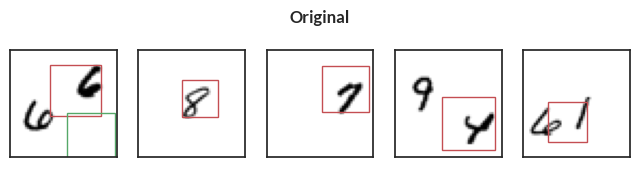

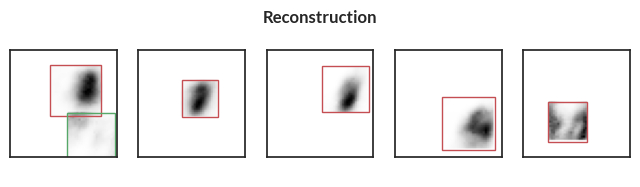

Epoch=1, total_epoch_step_time=96.62, p_loss=-326.14, q_loss=202.77853393554688
accuracy=0.8943666815757751, counts=[[19653   293     2     0]
 [  126 18607  1268    19]
 [    1  3925 15402   704]]


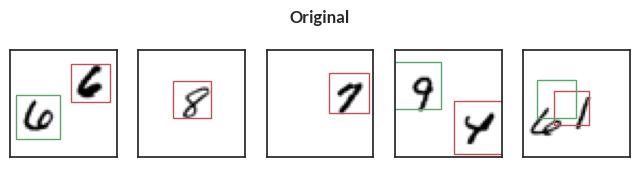

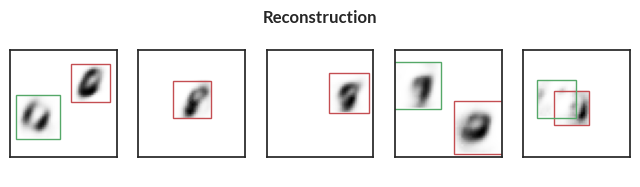

Epoch=2, total_epoch_step_time=144.79, p_loss=-356.15, q_loss=197.03016662597656
accuracy=0.9080333709716797, counts=[[19884    64     0     0]
 [  117 18883  1004    16]
 [    4  3952 15715   361]]


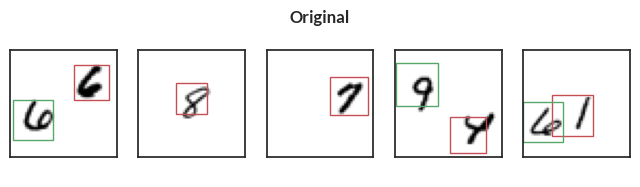

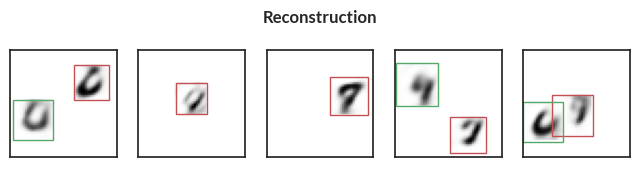

Epoch=3, total_epoch_step_time=193.55, p_loss=-369.71, q_loss=195.31753540039062
accuracy=0.9225666522979736, counts=[[19892    56     0     0]
 [   31 19349   624    16]
 [    1  3577 16113   341]]


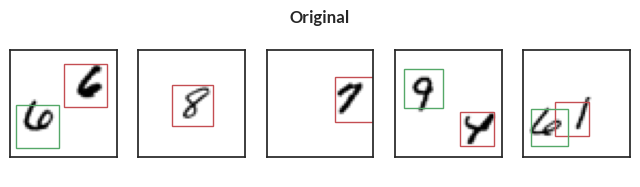

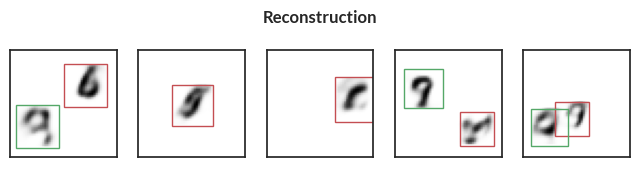

Epoch=4, total_epoch_step_time=242.89, p_loss=-378.98, q_loss=194.66940307617188
accuracy=0.9401000142097473, counts=[[19931    17     0     0]
 [   32 19391   591     6]
 [    0  2653 17084   295]]


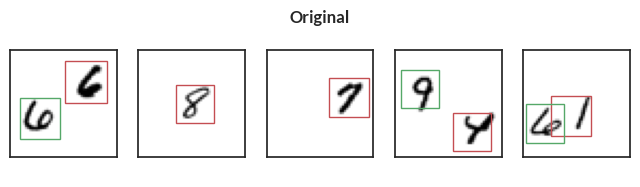

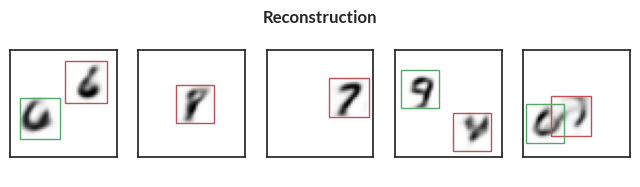

Epoch=5, total_epoch_step_time=288.67, p_loss=-385.56, q_loss=193.1349334716797
accuracy=0.9377333521842957, counts=[[19934    14     0     0]
 [   12 19475   529     4]
 [    0  3002 16855   175]]


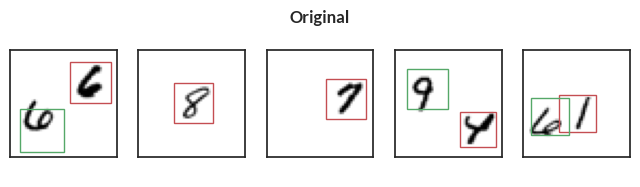

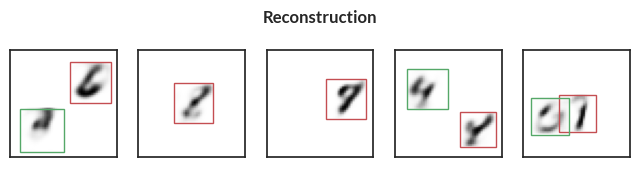

Epoch=6, total_epoch_step_time=341.60, p_loss=-390.80, q_loss=192.2410125732422
accuracy=0.946399986743927, counts=[[19938    10     0     0]
 [    8 19457   549     6]
 [    4  2390 17389   249]]


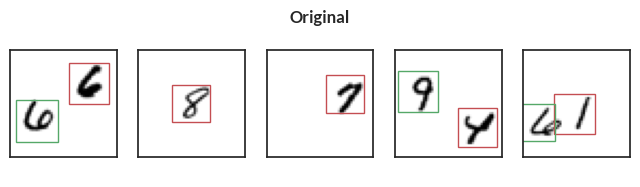

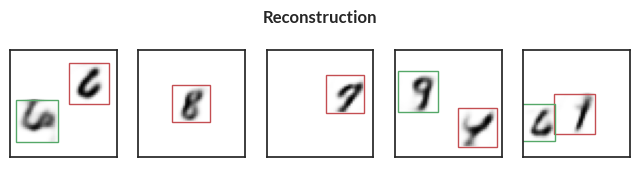

Epoch=7, total_epoch_step_time=394.24, p_loss=-390.45, q_loss=193.46792602539062
accuracy=0.9410666823387146, counts=[[19937    11     0     0]
 [   10 19611   395     4]
 [    3  2987 16916   126]]


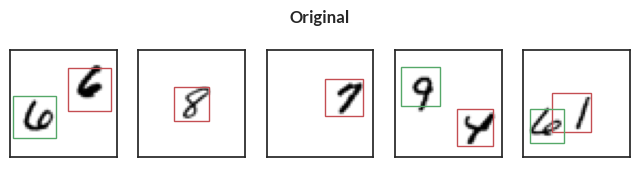

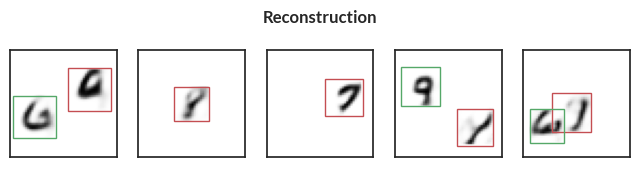

Epoch=8, total_epoch_step_time=446.75, p_loss=-395.93, q_loss=192.46572875976562
accuracy=0.9383167028427124, counts=[[19941     7     0     0]
 [   12 19868   140     0]
 [    2  3463 16490    77]]


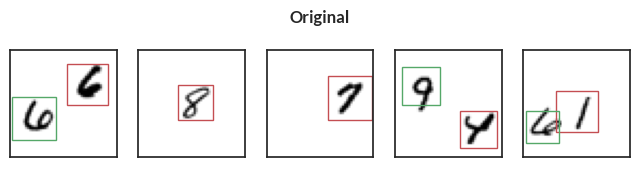

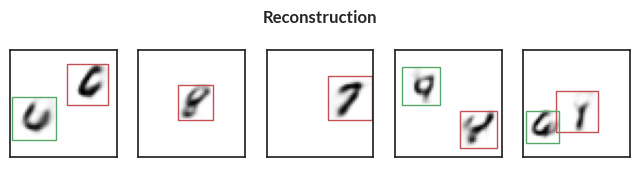

Epoch=9, total_epoch_step_time=498.33, p_loss=-394.95, q_loss=193.80821228027344
accuracy=0.9491666555404663, counts=[[19942     6     0     0]
 [    4 19749   265     2]
 [    3  2646 17259   124]]


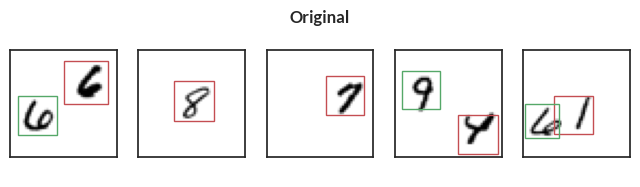

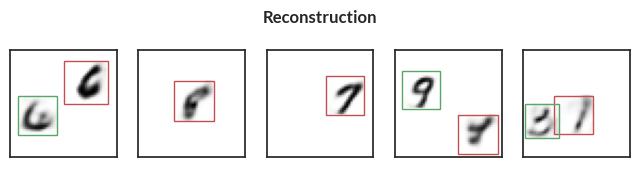

Epoch=10, total_epoch_step_time=550.41, p_loss=-398.40, q_loss=193.9649658203125
accuracy=0.9555833339691162, counts=[[19941     7     0     0]
 [    2 19453   560     5]
 [    2  1857 17941   232]]


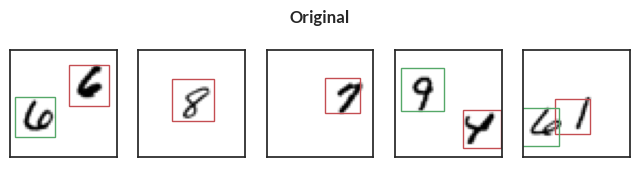

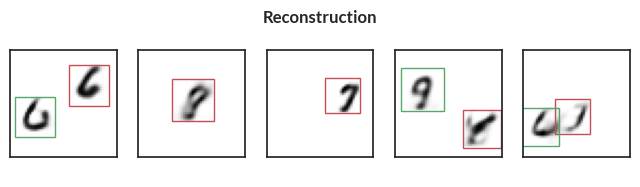

Epoch=11, total_epoch_step_time=602.80, p_loss=-399.09, q_loss=194.21884155273438
accuracy=0.9538333415985107, counts=[[19941     7     0     0]
 [    5 19413   600     2]
 [    4  1912 17876   240]]


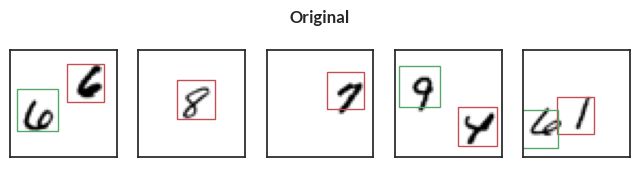

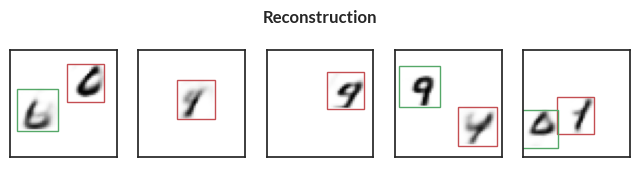

Epoch=12, total_epoch_step_time=655.01, p_loss=-401.62, q_loss=192.5127410888672
accuracy=0.9555333256721497, counts=[[19937    11     0     0]
 [    1 19766   251     2]
 [    2  2275 17629   126]]


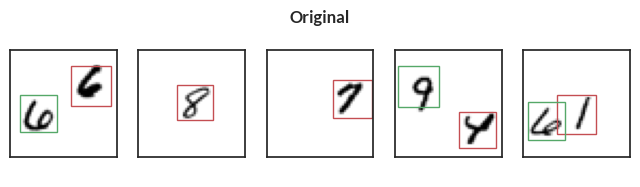

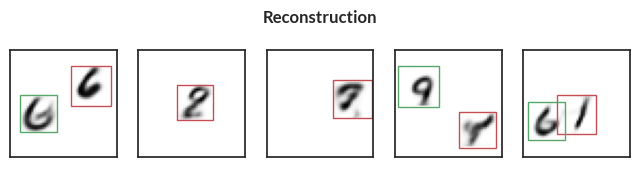

Epoch=13, total_epoch_step_time=707.50, p_loss=-404.35, q_loss=192.01788330078125
accuracy=0.9574166536331177, counts=[[19940     8     0     0]
 [    3 19726   288     3]
 [    3  2106 17779   144]]


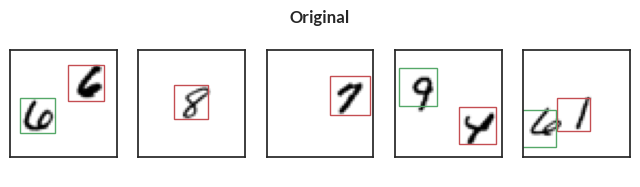

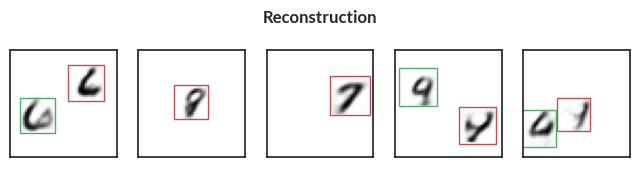

Epoch=14, total_epoch_step_time=759.80, p_loss=-404.86, q_loss=192.78382873535156
accuracy=0.9530166983604431, counts=[[19937    11     0     0]
 [    3 19857   159     1]
 [    0  2557 17387    88]]


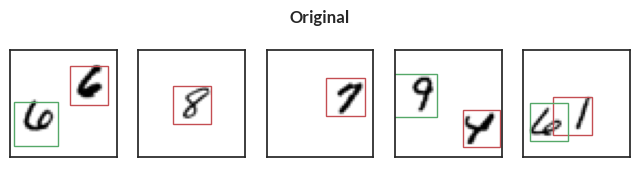

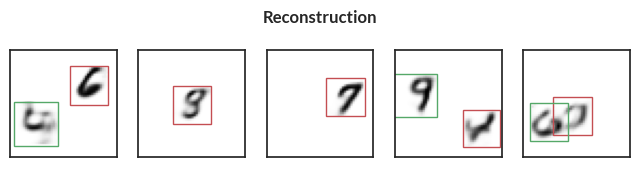

Epoch=15, total_epoch_step_time=812.25, p_loss=-405.25, q_loss=193.43624877929688
accuracy=0.9463000297546387, counts=[[19939     9     0     0]
 [    2 19895   122     1]
 [    1  3042 16944    45]]


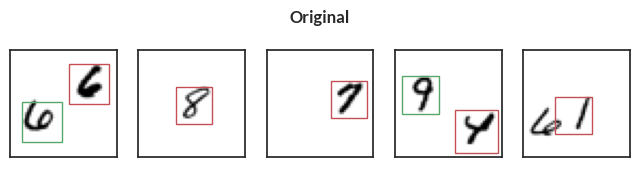

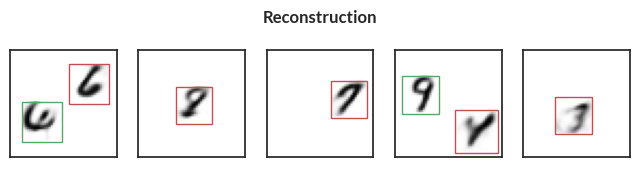

Epoch=16, total_epoch_step_time=864.88, p_loss=-406.53, q_loss=193.20498657226562
accuracy=0.9563500285148621, counts=[[19935    13     0     0]
 [    2 19776   241     1]
 [    3  2237 17670   122]]


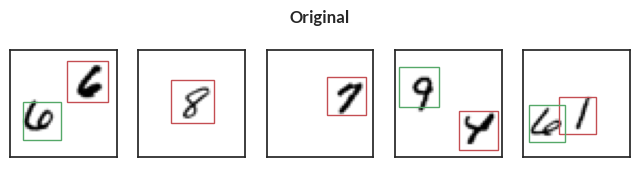

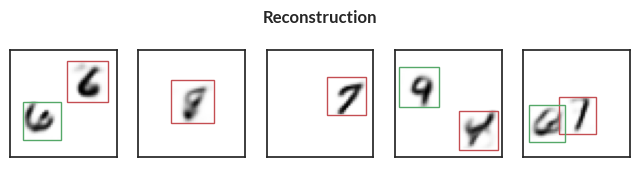

Epoch=17, total_epoch_step_time=913.57, p_loss=-407.97, q_loss=190.64523315429688
accuracy=0.9576666951179504, counts=[[19940     8     0     0]
 [    2 19821   196     1]
 [    2  2244 17699    87]]


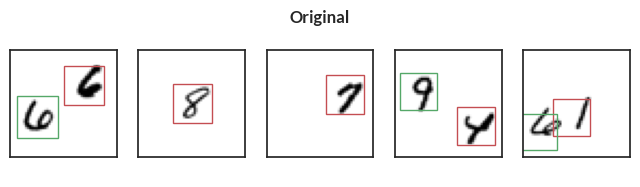

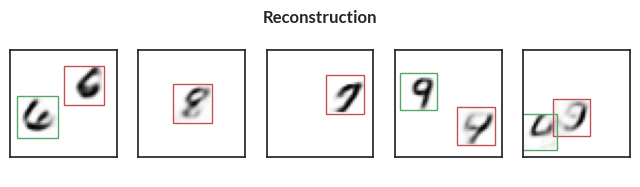

Epoch=18, total_epoch_step_time=954.95, p_loss=-406.52, q_loss=186.58750915527344
accuracy=0.958050012588501, counts=[[19942     6     0     0]
 [    2 19813   204     1]
 [    2  2215 17728    87]]


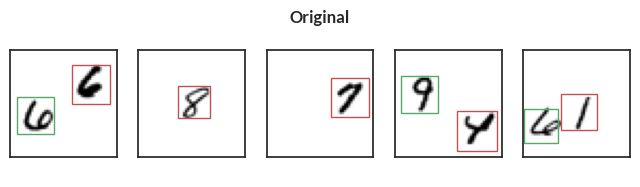

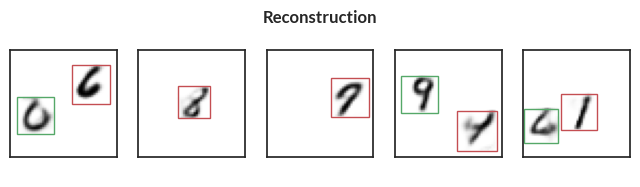

Epoch=19, total_epoch_step_time=1002.89, p_loss=-403.96, q_loss=183.32118225097656
accuracy=0.9572833180427551, counts=[[19943     5     0     0]
 [    3 19852   162     3]
 [    2  2318 17642    70]]


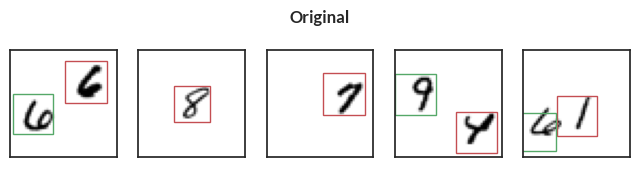

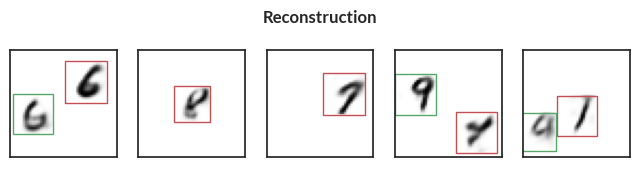

Epoch=20, total_epoch_step_time=1055.30, p_loss=-401.44, q_loss=179.0220489501953
accuracy=0.9569166898727417, counts=[[19942     6     0     0]
 [    1 19834   182     3]
 [    2  2211 17639   180]]


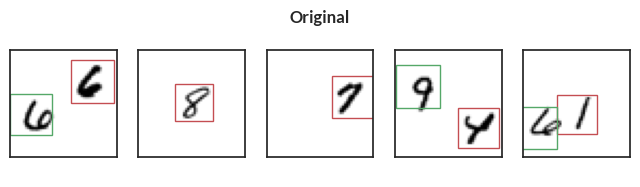

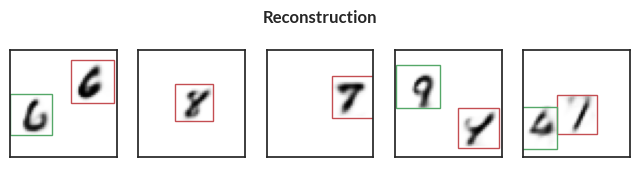

In [17]:
key, sub_key = jax.random.split(key)
(p_losses, q_losses), accuracy, wall_clock_times, params = train(
    sub_key, learning_rate=1.0e-4, n=10, batch_size=1, num_epochs=20
)

In [18]:
import pandas as pd

arr = np.array([p_losses, q_losses, accuracy, wall_clock_times])
df = pd.DataFrame(arr.T, columns=["P Loss", "Q Loss", "Accuracy", "Epoch wall clock times"])
df.to_csv("./training_runs/grasp_air_rws_10_mvd_batch_size_1_epochs_21_mccoy_prior.csv", index=False)

Epoch=0, total_epoch_step_time=9.99, p_loss=-223.45, q_loss=201.2074432373047
accuracy=0.6510833501815796, counts=[[19372   563    13     0]
 [  958 18784   273     5]
 [  147 18912   909    64]]


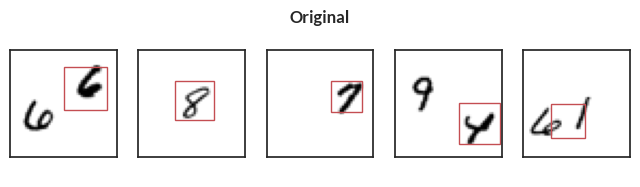

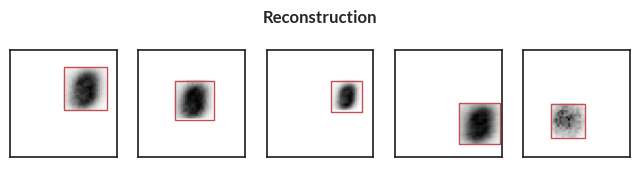

Epoch=1, total_epoch_step_time=20.53, p_loss=-306.30, q_loss=212.88624572753906
accuracy=0.6801333427429199, counts=[[19721   226     1     0]
 [  311 19567   140     2]
 [   43 18203  1520   266]]


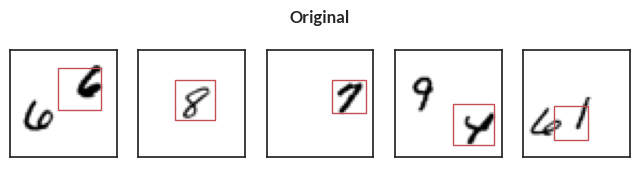

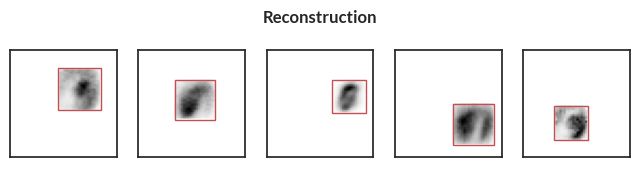

Epoch=2, total_epoch_step_time=31.05, p_loss=-324.99, q_loss=209.0303497314453
accuracy=0.6954333186149597, counts=[[19871    77     0     0]
 [  117 19782   115     6]
 [   16 17590  2073   353]]


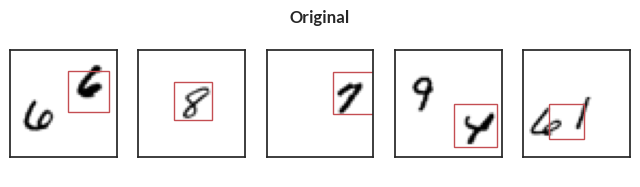

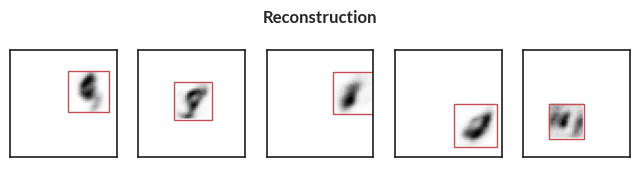

Epoch=3, total_epoch_step_time=41.60, p_loss=-336.82, q_loss=206.14947509765625
accuracy=0.7629666924476624, counts=[[19912    36     0     0]
 [   36 18973   917    94]
 [    5 11044  6893  2090]]


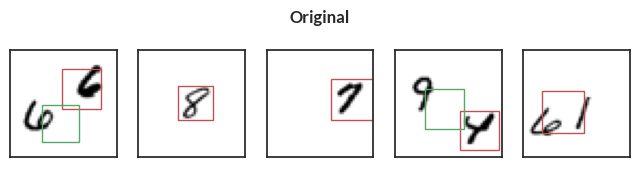

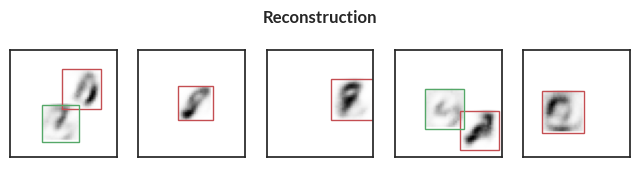

Epoch=4, total_epoch_step_time=52.30, p_loss=-344.67, q_loss=205.03636169433594
accuracy=0.7837333679199219, counts=[[19916    32     0     0]
 [   59 19770   186     5]
 [    9 12437  7338   248]]


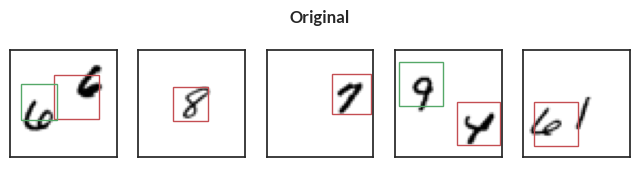

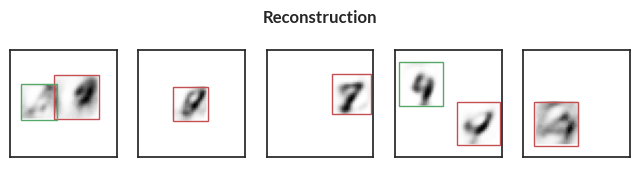

Epoch=5, total_epoch_step_time=61.20, p_loss=-356.94, q_loss=200.29554748535156
accuracy=0.8500833511352539, counts=[[19924    24     0     0]
 [   41 19419   550    10]
 [    8  7620 11662   742]]


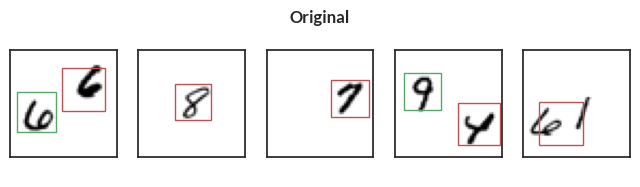

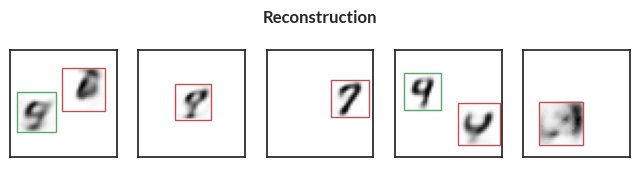

Epoch=6, total_epoch_step_time=71.64, p_loss=-364.65, q_loss=199.65023803710938
accuracy=0.8568500280380249, counts=[[19931    17     0     0]
 [   33 19768   216     3]
 [    7  8057 11712   256]]


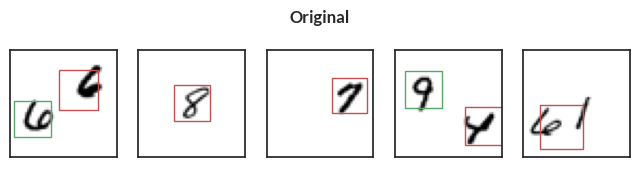

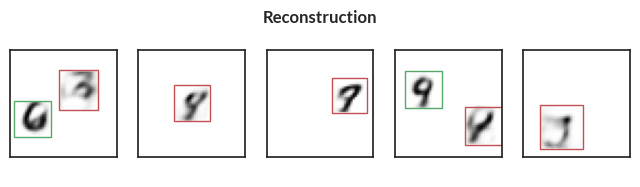

Epoch=7, total_epoch_step_time=82.29, p_loss=-369.25, q_loss=199.8097381591797
accuracy=0.9073666930198669, counts=[[19921    27     0     0]
 [   12 19429   571     8]
 [    9  4428 15092   503]]


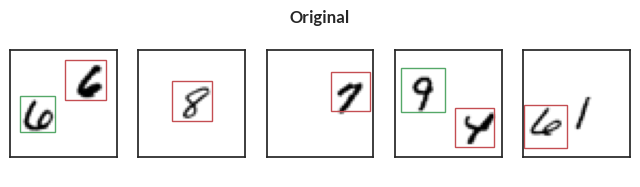

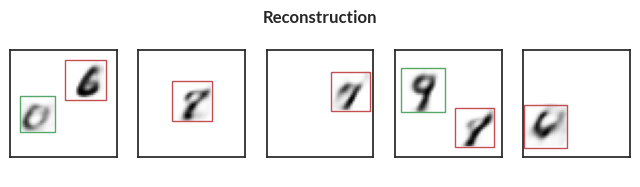

Epoch=8, total_epoch_step_time=92.92, p_loss=-373.91, q_loss=200.01077270507812
accuracy=0.9147166609764099, counts=[[19899    49     0     0]
 [    4 19340   670     6]
 [    2  3966 15644   420]]


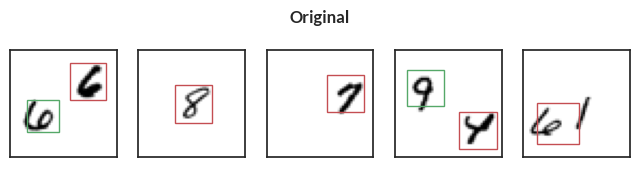

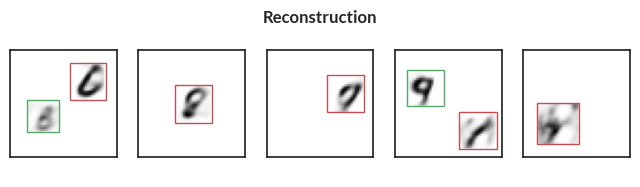

Epoch=9, total_epoch_step_time=103.56, p_loss=-379.12, q_loss=198.99319458007812
accuracy=0.9245833158493042, counts=[[19934    14     0     0]
 [   11 19142   860     7]
 [    8  3271 16399   354]]


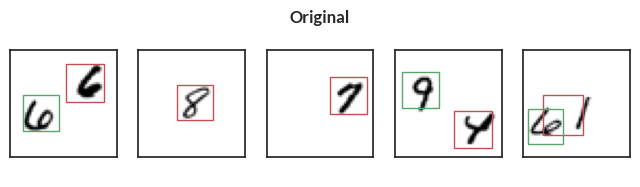

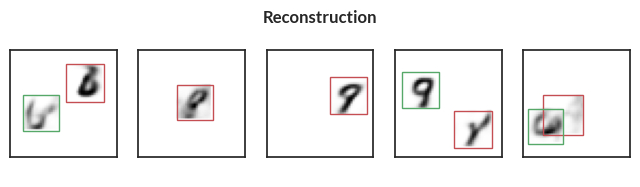

Epoch=10, total_epoch_step_time=114.24, p_loss=-381.64, q_loss=197.5020751953125
accuracy=0.9271833300590515, counts=[[19927    21     0     0]
 [   11 19618   383     8]
 [    3  3747 16086   196]]


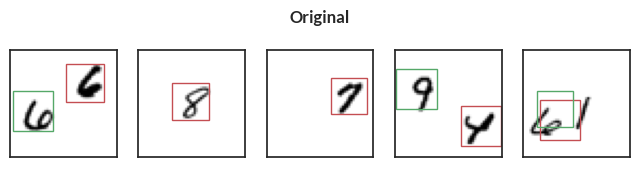

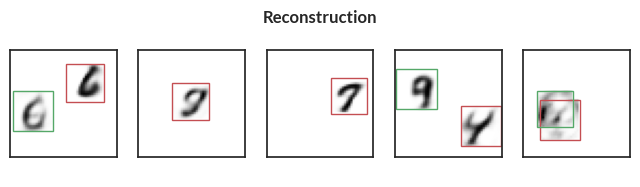

Epoch=11, total_epoch_step_time=123.91, p_loss=-382.77, q_loss=199.29440307617188
accuracy=0.9339166879653931, counts=[[19942     6     0     0]
 [   28 19548   441     3]
 [    9  3244 16545   234]]


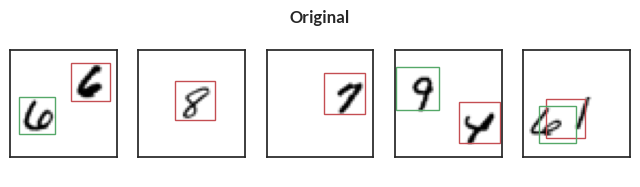

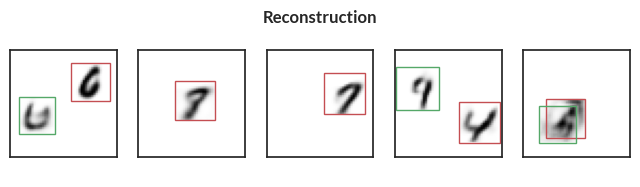

Epoch=12, total_epoch_step_time=134.51, p_loss=-387.19, q_loss=198.01495361328125
accuracy=0.9375666975975037, counts=[[19937    11     0     0]
 [   26 19449   542     3]
 [    6  2920 16868   238]]


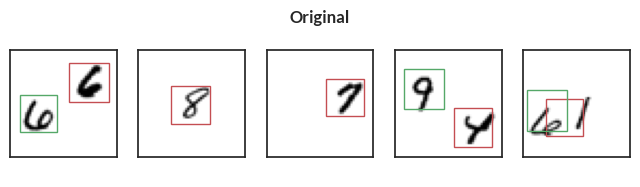

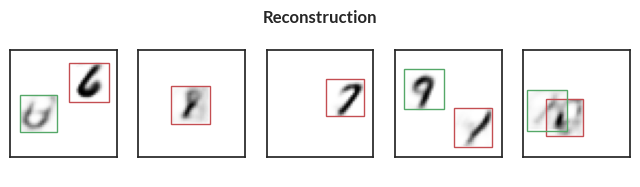

Epoch=13, total_epoch_step_time=145.05, p_loss=-388.53, q_loss=197.90536499023438
accuracy=0.9422333240509033, counts=[[19936    12     0     0]
 [    8 19597   408     7]
 [    9  2727 17001   295]]


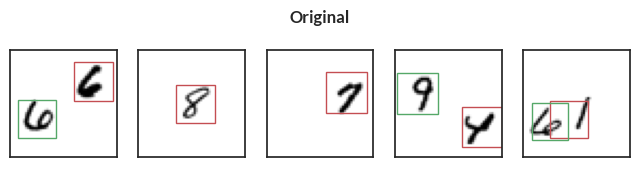

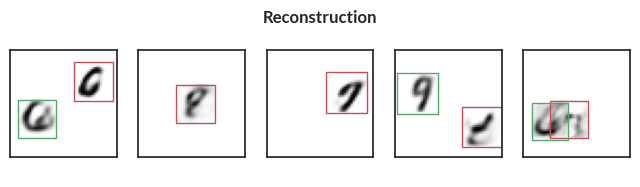

Epoch=14, total_epoch_step_time=155.59, p_loss=-388.11, q_loss=199.4213409423828
accuracy=0.9405666589736938, counts=[[19941     7     0     0]
 [    7 19759   253     1]
 [    4  3187 16734   107]]


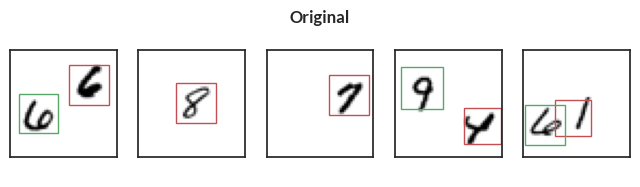

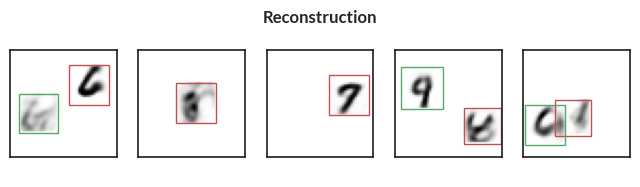

Epoch=15, total_epoch_step_time=166.11, p_loss=-390.00, q_loss=199.1395721435547
accuracy=0.9437666535377502, counts=[[19940     8     0     0]
 [   12 19707   295     6]
 [    4  2912 16979   137]]


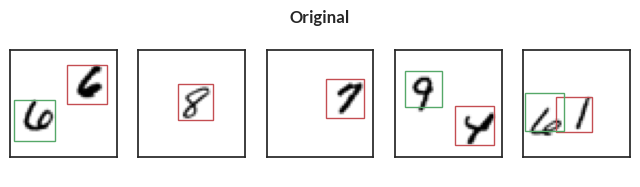

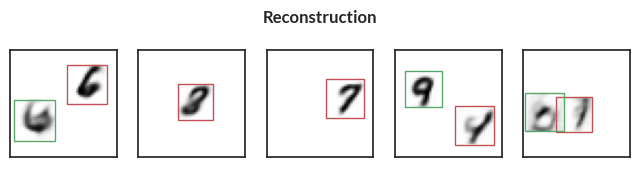

Epoch=16, total_epoch_step_time=176.57, p_loss=-390.24, q_loss=199.08534240722656
accuracy=0.945983350276947, counts=[[19937    11     0     0]
 [    9 19626   369    16]
 [    1  2704 17196   131]]


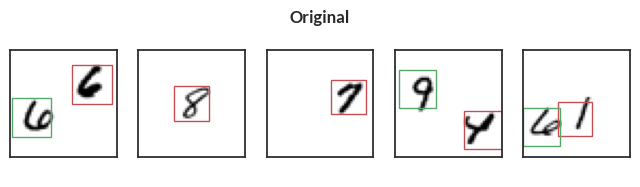

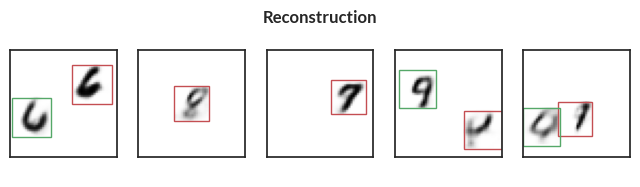

Epoch=17, total_epoch_step_time=187.11, p_loss=-393.51, q_loss=197.4565887451172
accuracy=0.9480167031288147, counts=[[19944     4     0     0]
 [   15 19709   293     3]
 [    7  2721 17228    76]]


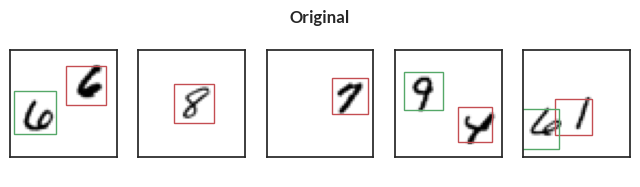

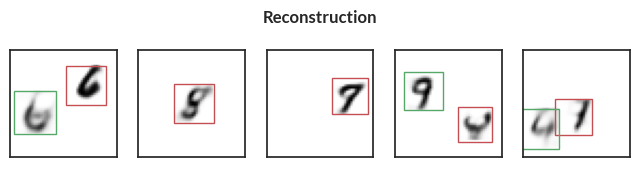

Epoch=18, total_epoch_step_time=196.44, p_loss=-396.67, q_loss=196.90521240234375
accuracy=0.9508500099182129, counts=[[19938    10     0     0]
 [    5 19735   278     2]
 [    5  2549 17378   100]]


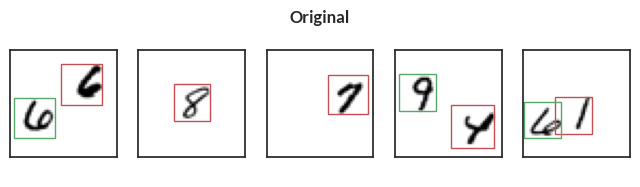

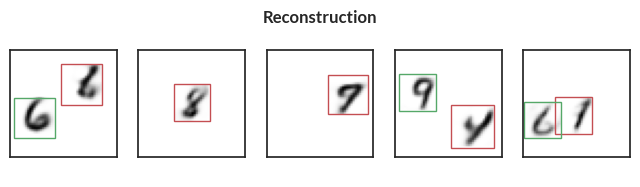

Epoch=19, total_epoch_step_time=207.08, p_loss=-396.57, q_loss=197.36683654785156
accuracy=0.9577833414077759, counts=[[19943     5     0     0]
 [   10 19718   288     4]
 [    4  2038 17806   184]]


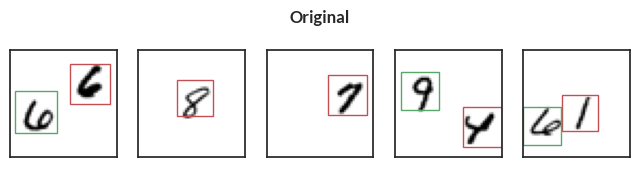

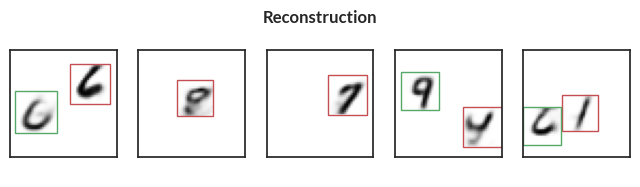

Epoch=20, total_epoch_step_time=217.77, p_loss=-399.01, q_loss=196.3762664794922
accuracy=0.956683337688446, counts=[[19940     8     0     0]
 [    4 19793   222     1]
 [    4  2310 17668    50]]


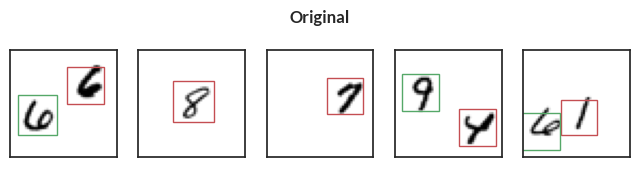

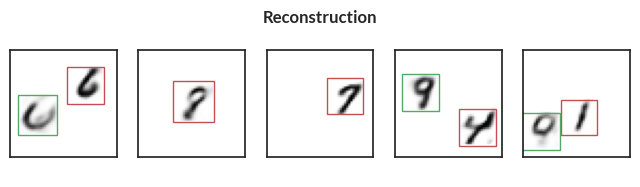

Epoch=21, total_epoch_step_time=228.44, p_loss=-397.97, q_loss=197.59268188476562
accuracy=0.9520833492279053, counts=[[19944     4     0     0]
 [    9 19778   231     2]
 [    5  2545 17403    79]]


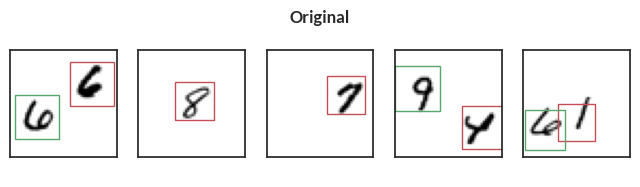

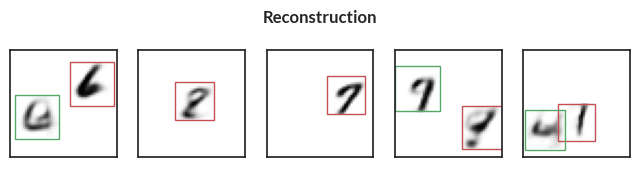

Epoch=22, total_epoch_step_time=239.12, p_loss=-398.04, q_loss=198.24856567382812
accuracy=0.9560500383377075, counts=[[19938    10     0     0]
 [    7 19335   674     4]
 [    2  1789 18090   151]]


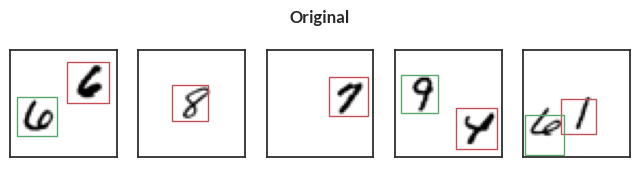

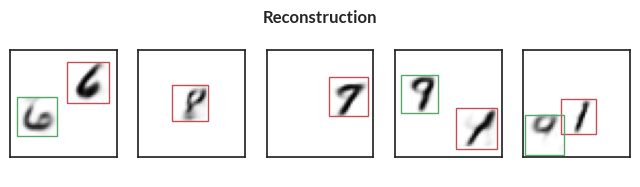

Epoch=23, total_epoch_step_time=249.76, p_loss=-398.15, q_loss=198.1184844970703
accuracy=0.9573500156402588, counts=[[19942     6     0     0]
 [    3 19413   601     3]
 [    2  1811 18086   133]]


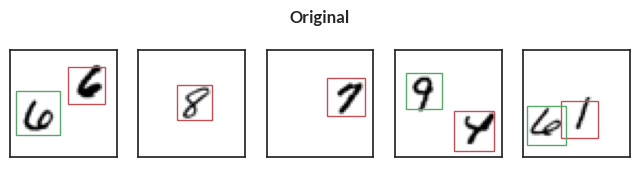

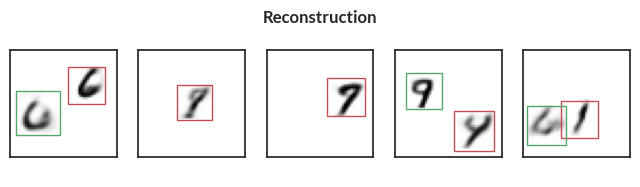

Epoch=24, total_epoch_step_time=259.57, p_loss=-399.14, q_loss=197.99192810058594
accuracy=0.9567333459854126, counts=[[19942     6     0     0]
 [    8 19643   365     4]
 [    7  2142 17819    64]]


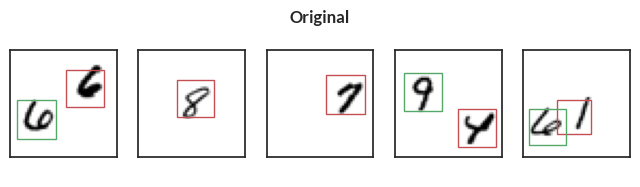

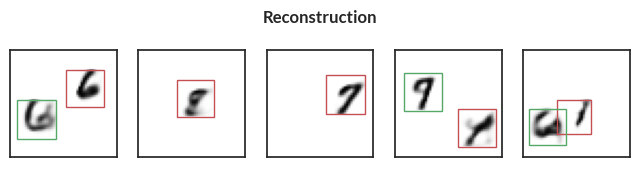

Epoch=25, total_epoch_step_time=268.80, p_loss=-401.31, q_loss=197.42144775390625
accuracy=0.9509666562080383, counts=[[19944     4     0     0]
 [    4 19745   271     0]
 [    7  2622 17369    34]]


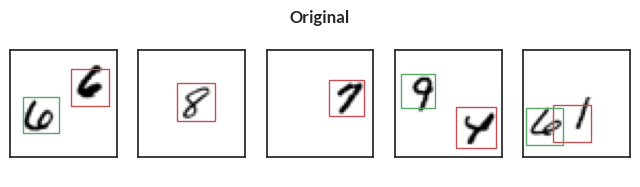

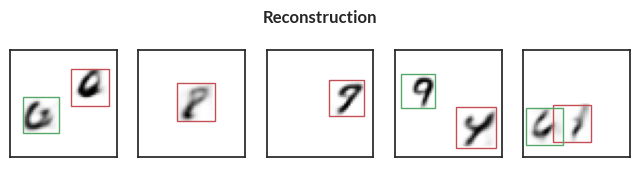

Epoch=26, total_epoch_step_time=278.16, p_loss=-400.56, q_loss=197.99710083007812
accuracy=0.9587500095367432, counts=[[19944     4     0     0]
 [    3 19779   235     3]
 [    3  2180 17802    47]]


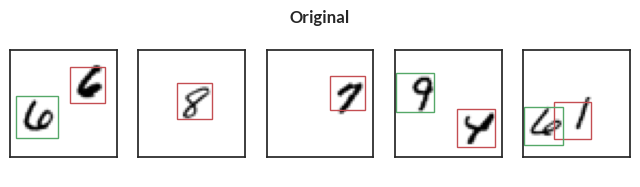

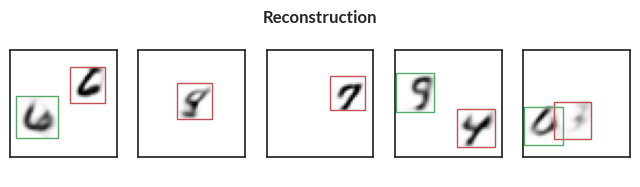

Epoch=27, total_epoch_step_time=287.53, p_loss=-403.34, q_loss=196.65220642089844
accuracy=0.958733320236206, counts=[[19937    11     0     0]
 [    8 19771   240     1]
 [    2  2172 17816    42]]


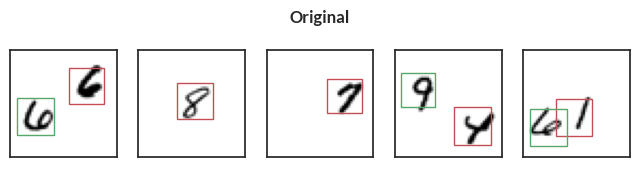

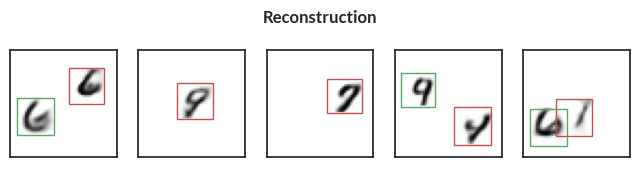

Epoch=28, total_epoch_step_time=298.08, p_loss=-404.16, q_loss=195.6787872314453
accuracy=0.9580000042915344, counts=[[19942     6     0     0]
 [    4 19722   293     1]
 [    1  2135 17816    80]]


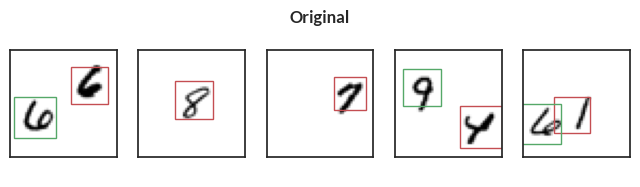

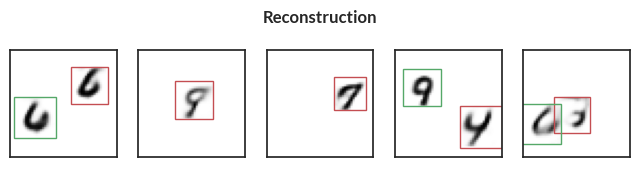

Epoch=29, total_epoch_step_time=308.50, p_loss=-402.07, q_loss=197.88919067382812
accuracy=0.9599000215530396, counts=[[19938    10     0     0]
 [    4 19605   408     3]
 [    5  1868 18051   108]]


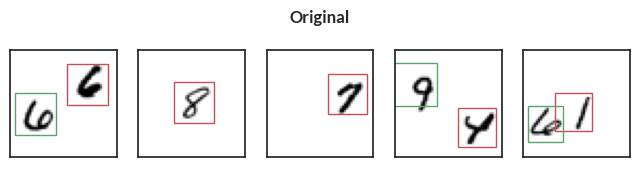

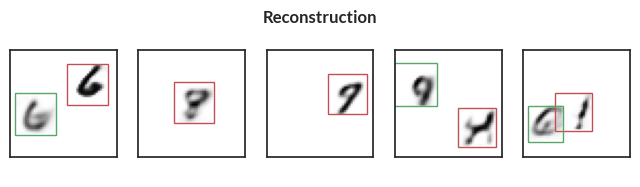

Epoch=30, total_epoch_step_time=319.05, p_loss=-401.76, q_loss=197.79660034179688
accuracy=0.9610166549682617, counts=[[19943     5     0     0]
 [    4 19748   267     1]
 [    0  1997 17970    65]]


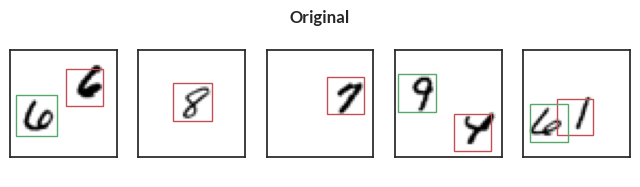

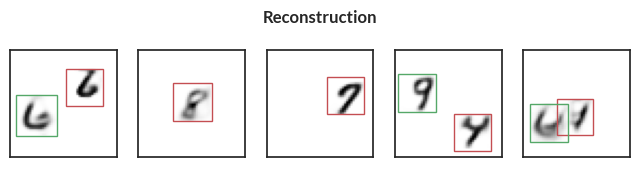

Epoch=31, total_epoch_step_time=328.80, p_loss=-402.58, q_loss=197.06507873535156
accuracy=0.9629666805267334, counts=[[19944     4     0     0]
 [    6 19766   248     0]
 [    3  1877 18068    84]]


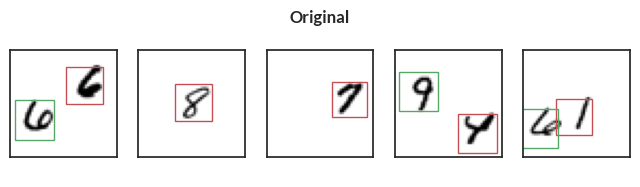

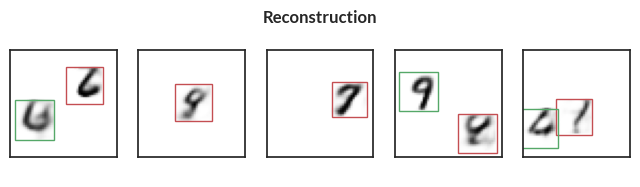

Epoch=32, total_epoch_step_time=337.93, p_loss=-403.98, q_loss=197.896484375
accuracy=0.961316704750061, counts=[[19942     6     0     0]
 [    2 19749   267     2]
 [    3  1969 17988    72]]


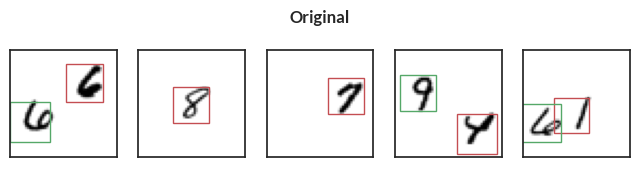

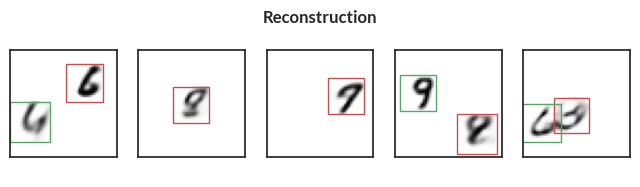

Epoch=33, total_epoch_step_time=348.66, p_loss=-405.05, q_loss=196.0694580078125
accuracy=0.9600499868392944, counts=[[19931    17     0     0]
 [    4 19856   157     3]
 [    6  2170 17816    40]]


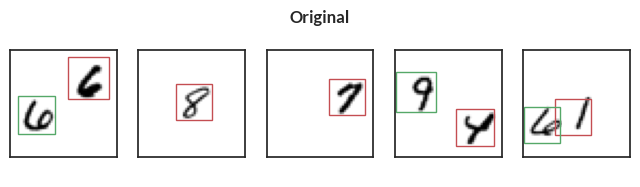

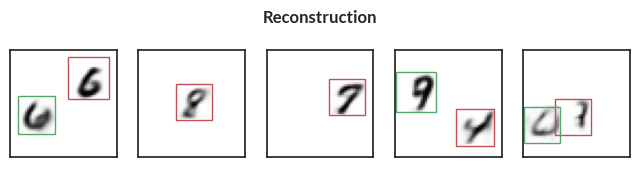

Epoch=34, total_epoch_step_time=359.28, p_loss=-404.01, q_loss=197.7519989013672
accuracy=0.9595500230789185, counts=[[19945     3     0     0]
 [    8 19740   271     1]
 [    8  2085 17888    51]]


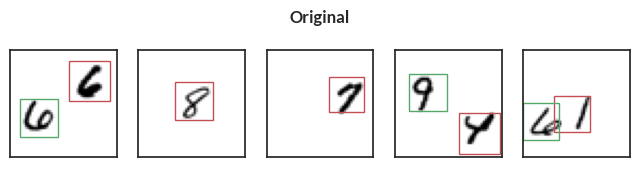

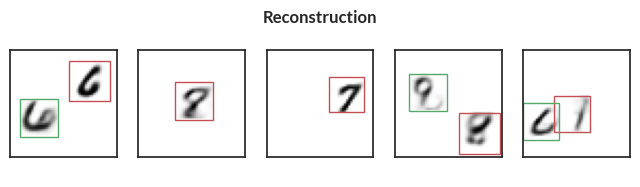

Epoch=35, total_epoch_step_time=369.80, p_loss=-406.16, q_loss=195.6112518310547
accuracy=0.9616667032241821, counts=[[19933    15     0     0]
 [    9 19769   241     1]
 [    5  1977 17998    52]]


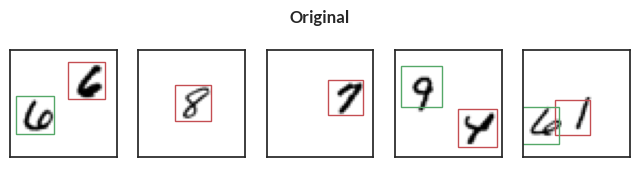

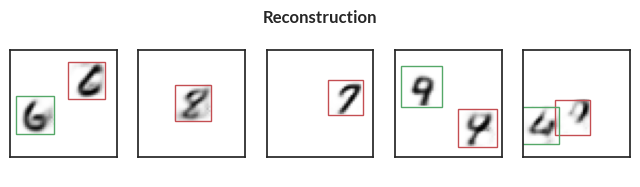

Epoch=36, total_epoch_step_time=380.37, p_loss=-406.21, q_loss=196.65367126464844
accuracy=0.9605166912078857, counts=[[19938    10     0     0]
 [    2 19816   201     1]
 [    4  2074 17877    77]]


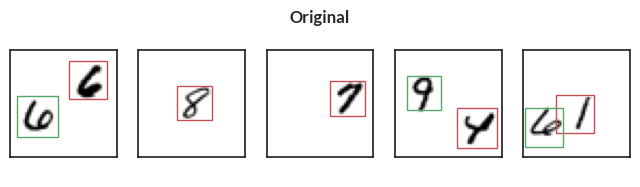

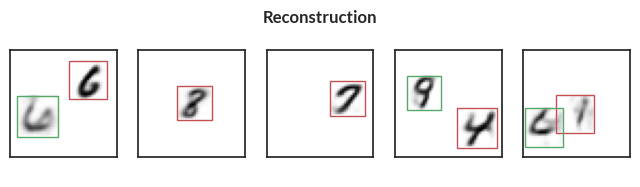

Epoch=37, total_epoch_step_time=390.28, p_loss=-404.86, q_loss=197.2697296142578
accuracy=0.959600031375885, counts=[[19940     8     0     0]
 [   10 19741   269     0]
 [    2  2050 17895    85]]


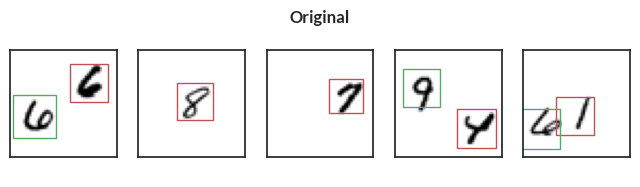

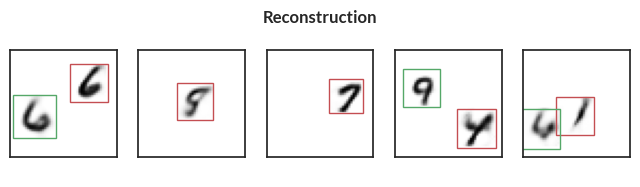

Epoch=38, total_epoch_step_time=400.92, p_loss=-405.97, q_loss=197.72879028320312
accuracy=0.9638333320617676, counts=[[19942     6     0     0]
 [    8 19838   174     0]
 [    8  1924 18050    50]]


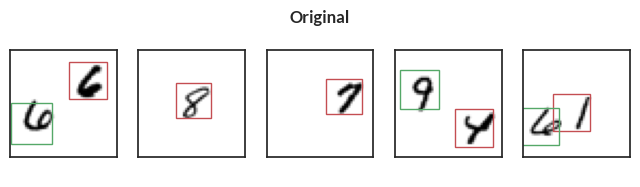

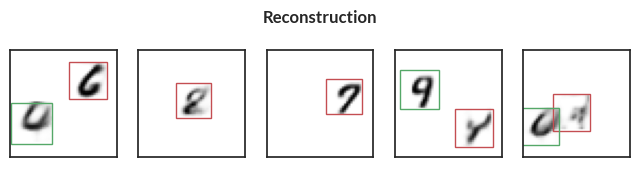

Epoch=39, total_epoch_step_time=411.53, p_loss=-406.22, q_loss=197.82994079589844
accuracy=0.9614666700363159, counts=[[19939     9     0     0]
 [    8 19877   135     0]
 [    5  2104 17872    51]]


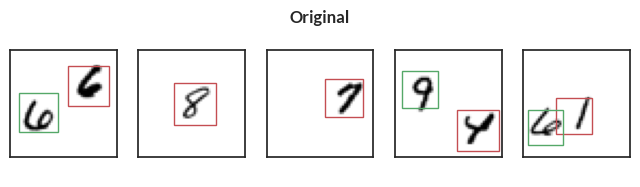

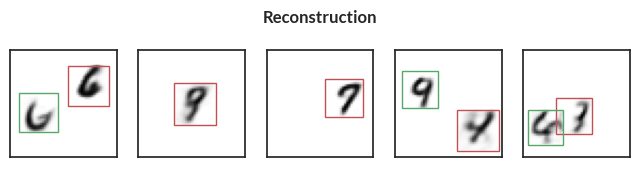

Epoch=40, total_epoch_step_time=422.13, p_loss=-406.87, q_loss=197.7266845703125
accuracy=0.9650499820709229, counts=[[19938    10     0     0]
 [    3 19807   209     1]
 [    5  1808 18158    61]]


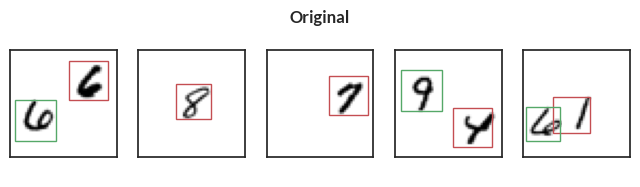

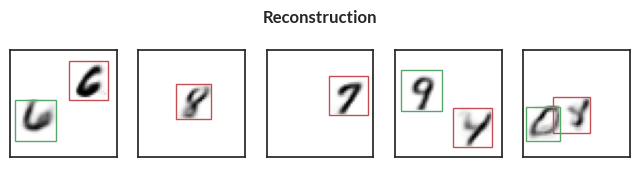

Epoch=41, total_epoch_step_time=432.72, p_loss=-407.88, q_loss=196.56478881835938
accuracy=0.9601666927337646, counts=[[19941     7     0     0]
 [    5 19903   110     2]
 [    7  2209 17766    50]]


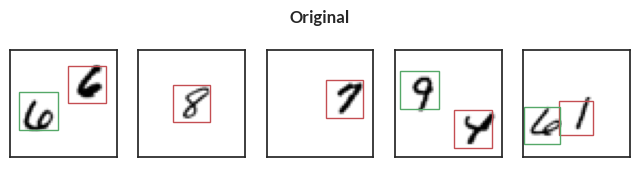

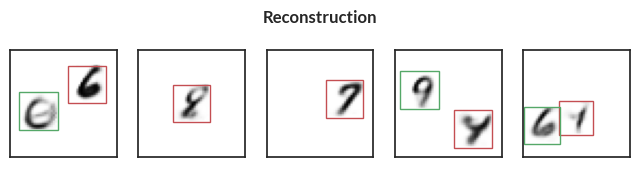

Epoch=42, total_epoch_step_time=442.74, p_loss=-407.91, q_loss=196.46156311035156
accuracy=0.9653833508491516, counts=[[19943     5     0     0]
 [    2 19746   270     2]
 [    4  1731 18234    63]]


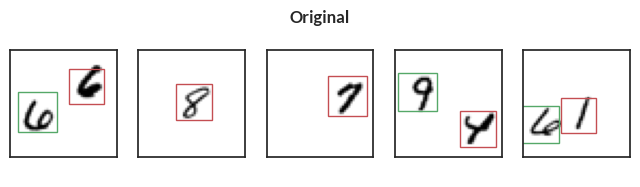

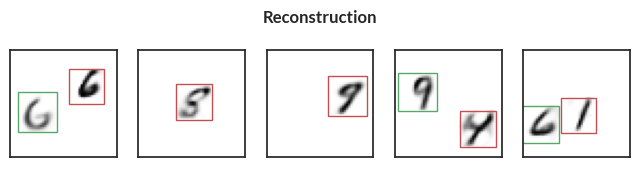

Epoch=43, total_epoch_step_time=452.68, p_loss=-409.36, q_loss=196.42588806152344
accuracy=0.9635833501815796, counts=[[19934    14     0     0]
 [    6 19875   138     1]
 [    1  1979 18006    46]]


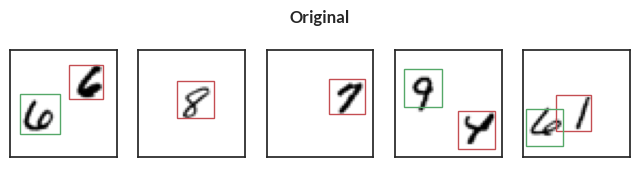

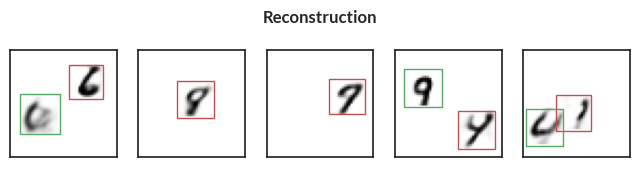

Epoch=44, total_epoch_step_time=463.27, p_loss=-408.14, q_loss=198.12037658691406
accuracy=0.9609500169754028, counts=[[19939     9     0     0]
 [    2 19886   128     4]
 [    2  2133 17832    65]]


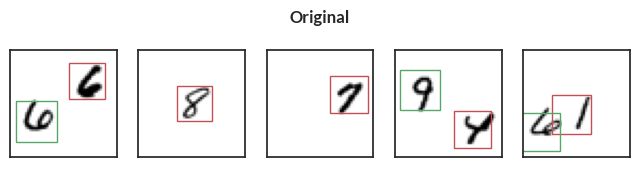

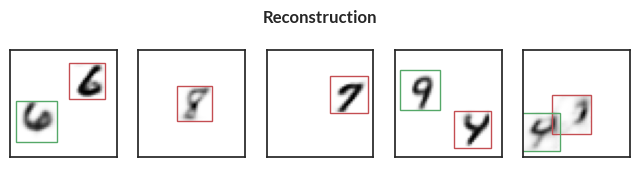

Epoch=45, total_epoch_step_time=473.88, p_loss=-409.28, q_loss=197.3065948486328
accuracy=0.9646833539009094, counts=[[19941     7     0     0]
 [    4 19746   265     5]
 [    1  1663 18194   174]]


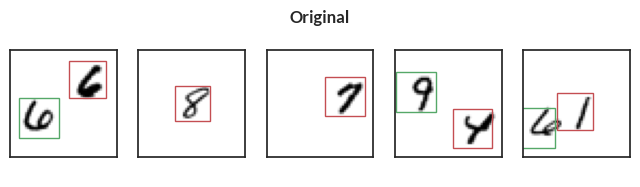

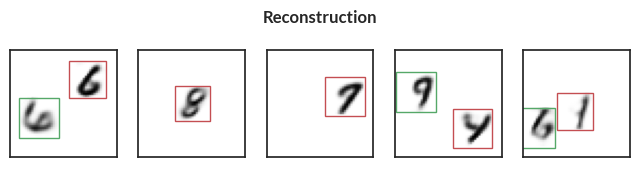

Epoch=46, total_epoch_step_time=484.53, p_loss=-410.09, q_loss=196.17965698242188
accuracy=0.9640333652496338, counts=[[19938    10     0     0]
 [    7 19782   229     2]
 [    3  1804 18122   103]]


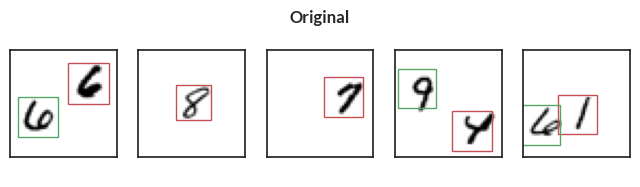

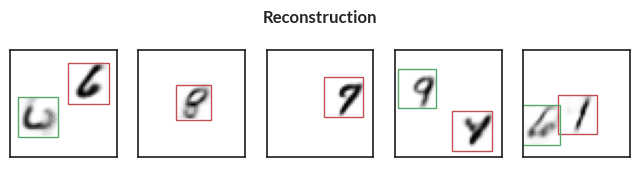

Epoch=47, total_epoch_step_time=494.87, p_loss=-408.88, q_loss=196.9137725830078
accuracy=0.9660666584968567, counts=[[19946     2     0     0]
 [    2 19812   205     1]
 [    2  1725 18206    99]]


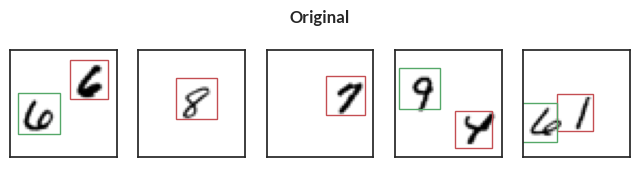

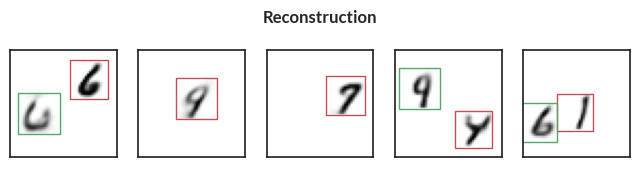

Epoch=48, total_epoch_step_time=503.86, p_loss=-409.36, q_loss=196.93312072753906
accuracy=0.9660500288009644, counts=[[19943     5     0     0]
 [    1 19877   140     2]
 [    2  1837 18143    50]]


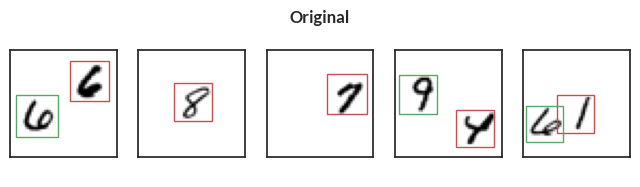

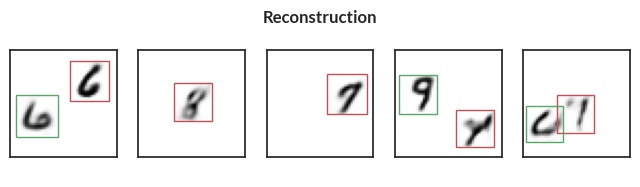

Epoch=49, total_epoch_step_time=512.69, p_loss=-410.88, q_loss=195.91030883789062
accuracy=0.9637500047683716, counts=[[19942     6     0     0]
 [    4 19870   145     1]
 [    2  1987 18013    30]]


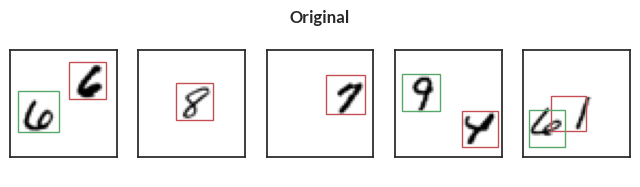

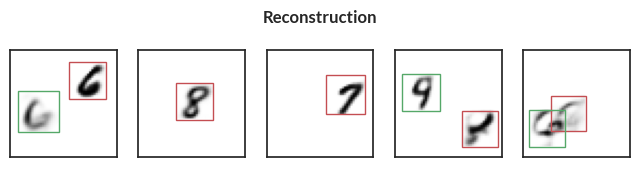

Epoch=50, total_epoch_step_time=521.20, p_loss=-409.36, q_loss=197.85565185546875
accuracy=0.9654833674430847, counts=[[19945     3     0     0]
 [    4 19834   181     1]
 [    2  1856 18150    24]]


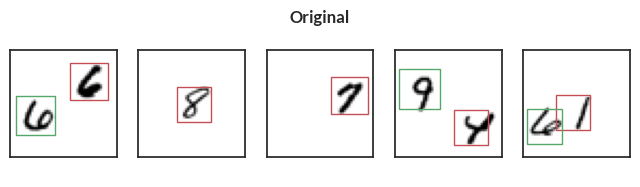

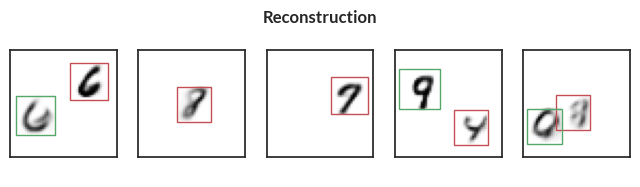

Epoch=51, total_epoch_step_time=529.73, p_loss=-409.05, q_loss=197.33555603027344
accuracy=0.9670500159263611, counts=[[19938    10     0     0]
 [    3 19793   222     2]
 [    1  1690 18292    49]]


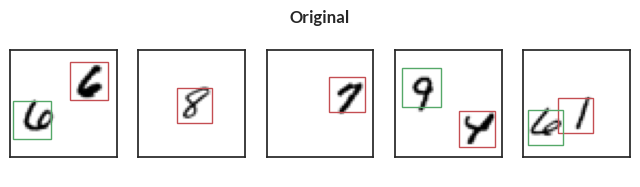

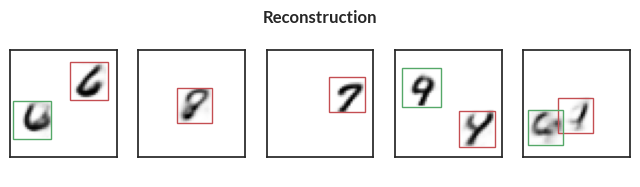

Epoch=52, total_epoch_step_time=538.33, p_loss=-409.12, q_loss=197.2040252685547
accuracy=0.9678333401679993, counts=[[19946     2     0     0]
 [    4 19826   189     1]
 [    3  1687 18298    44]]


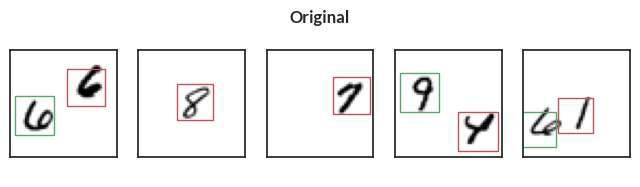

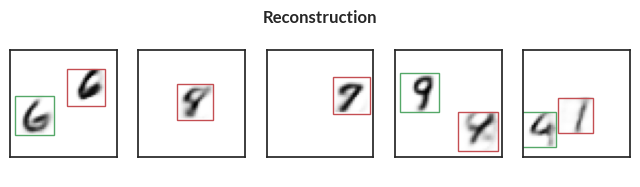

Epoch=53, total_epoch_step_time=546.68, p_loss=-410.63, q_loss=196.43966674804688
accuracy=0.9679833650588989, counts=[[19942     6     0     0]
 [    4 19785   229     2]
 [    1  1642 18352    37]]


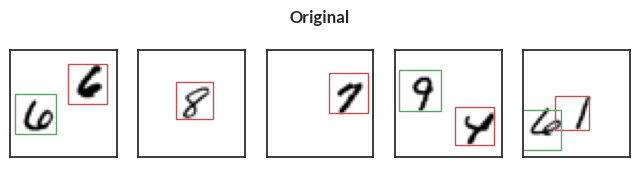

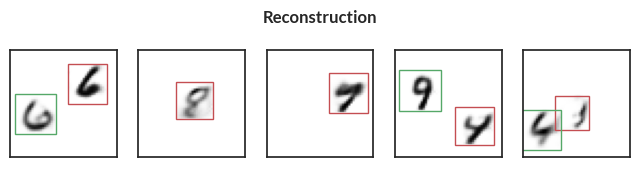

In [ ]:
key, sub_key = jax.random.split(key)
(p_losses, q_losses), accuracy, wall_clock_times, params = train(
    sub_key, learning_rate=1.0e-3, n=10, batch_size=64, num_epochs=200
)

In [ ]:
arr = np.array([p_losses, q_losses, accuracy, wall_clock_times])
df = pd.DataFrame(arr.T, columns=["P Loss", "Q Loss", "Accuracy", "Epoch wall clock times"])
df.to_csv("./training_runs/grasp_air_rws_10_mvd_epochs_201_mccoy_prior.csv", index=False)